#**Artificial Intelligence Project: Song Classification**

### Members:
- Samuel Soto
- George Trujillo


## Introduction

In recent years, streaming services with vast catalogs have become the primary medium through which most people listen to their favorite music. However, the sheer volume of available music can overwhelm users when they seek new music that matches their tastes. Consequently, streaming services have sought ways to categorize music to provide personalized recommendations. One method involves directly analyzing the information contained in a given song's audio file, calculating various metrics that serve as features.

In this project, we will examine data collected by a research group known as The Echo Nest. The goal is to review this dataset and classify songs as 'Hip-Hop' or 'Rock' automatically using an algorithm, without listening to a single song. This process involves cleaning the data, performing exploratory visualizations, augmenting the original dataset with new data from reliable sources, and preparing the data for use with machine learning models. Additionally, feature reduction techniques will be employed to streamline the data for machine learning algorithms.

The notebook will be structured as follows:
1. **Data Loading and Initial Exploration**: Load the provided datasets and perform an initial exploration.
2. **Exploratory Data Analysis (EDA)**: Conduct visualizations and summary statistics to understand the data better.
3. **Data Preparation**: Clean and prepare the data for model training, including handling missing values and normalizing features.
4. **Model Training and Evaluation**: Train and evaluate various machine learning models, tuning hyperparameters, and selecting the best model based on performance metrics.
5. **Deployment Plan**: Propose a deployment plan for the chosen model.
6. **Conclusion**: Summarize the findings and discuss the impact of the proposed solution in the context of the problem.



##**Dataset Loading and Description**

In [2]:
#Link to the environment
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Load datasets
echonest_metrics = pd.read_json('/content/drive/MyDrive/ProyectoIA/SegundaEntrega/data/echonest-metrics.json')
fma_rock_vs_hiphop = pd.read_csv('/content/drive/MyDrive/ProyectoIA/SegundaEntrega/data/fma-rock-vs-hiphop.csv')

echonest_metrics_info = echonest_metrics.info()




<class 'pandas.core.frame.DataFrame'>
Index: 13129 entries, 0 to 13128
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          13129 non-null  int64  
 1   acousticness      13129 non-null  float64
 2   danceability      13129 non-null  float64
 3   energy            13129 non-null  float64
 4   instrumentalness  13129 non-null  float64
 5   liveness          13129 non-null  float64
 6   speechiness       13129 non-null  float64
 7   tempo             13129 non-null  float64
 8   valence           13129 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


### Dataset issues and cleanup actions

#### `echonest-metrics.json`

1. **No null values ​​detected**: There are no columns with null values, so no cleanup is required in this regard.



In [5]:
fma_rock_vs_hiphop_info = fma_rock_vs_hiphop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17734 entries, 0 to 17733
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   track_id       17734 non-null  int64 
 1   bit_rate       17734 non-null  int64 
 2   comments       17734 non-null  int64 
 3   composer       166 non-null    object
 4   date_created   17734 non-null  object
 5   date_recorded  1898 non-null   object
 6   duration       17734 non-null  int64 
 7   favorites      17734 non-null  int64 
 8   genre_top      17734 non-null  object
 9   genres         17734 non-null  object
 10  genres_all     17734 non-null  object
 11  information    482 non-null    object
 12  interest       17734 non-null  int64 
 13  language_code  4089 non-null   object
 14  license        17714 non-null  object
 15  listens        17734 non-null  int64 
 16  lyricist       53 non-null     object
 17  number         17734 non-null  int64 
 18  publisher      52 non-null

#### `fma-rock-vs-hiphop.csv`

1. **Null values ​​in multiple columns**:
 - `composer`, `date_recorded`, `information`, `language_code`, `license`, `lyricist`, `publisher`.
 - **Action**: Decide whether to impute null values ​​with some value (for example, "Unknown" for texts or median for dates) or delete rows with many null values, depending on the importance of these columns to the analysis.

2. **Date format**:
 - Columns `date_created` and `date_recorded` are in text format.
 - **Action**: Convert these columns to datetime type to facilitate temporal analysis.

3. **Categorical columns**:
 - Columns like `genre_top`, `genres`, `genres_all`, `tags` may need to be converted to a more manageable format (e.g. lists or categories).
 - **Action**: Process lists of genres and tags for categorical analysis.

4. **Data consistency**:
 - Check consistency between related columns, such as `genre_top` and `genres`.
 - **Action**: Make sure top genres (`genre_top`) are included in genre lists (`genres`).




###1. **`echonest-metrics.json`**:
 - **Entries:** 13129
 - **Columns:** 9 (track_id, acousticness, danceability, energy, instrumentalness, liveness, speechiness, tempo, valence)
 - **First rows:**






In [6]:
echonest_metrics.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


Table of columns and descriptions for `echonest-metrics.json`

| Column             | Description                                                    |
|--------------------|----------------------------------------------------------------|
| `track_id`         | Unique identifier for the track                                |
| `acousticness`     | Confidence measure of whether the track is acoustic            |
| `danceability`     | Measure of how suitable the track is for dancing               |
| `energy`           | Measure of intensity and activity of the track                 |
| `instrumentalness` | Prediction of the presence of vocals in the track              |
| `liveness`         | Measure of the presence of a live audience in the recording    |
| `speechiness`      | Measure of the presence of spoken words in the track           |
| `tempo`            | Speed or pace of the track in beats per minute (BPM)           |
| `valence`          | Measure of the musical positiveness conveyed by the track      |

###2. **`fma-rock-vs-hiphop.csv`**:
 - **Entries:** 17734
 - **Columns:** 21 (track_id, bit_rate, comments, composer, date_created, date_recorded, duration, favorites, genre_top, genres, genres_all, information, interest, language_code, license, listens, lyricist, number, publisher, tags, title )
 - **First rows:**


In [7]:
fma_rock_vs_hiphop.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood




Table of columns and descriptions for `fma-rock-vs-hiphop.csv`

| Column             | Description                                                    |
|--------------------|----------------------------------------------------------------|
| `track_id`         | Unique identifier for the track                                |
| `bit_rate`         | Bit rate of the track (audio quality)                          |
| `comments`         | Number of comments on the track                                |
| `composer`         | Name of the track's composer                                   |
| `date_created`     | Creation date of the track                                     |
| `date_recorded`    | Recording date of the track                                    |
| `duration`         | Duration of the track in seconds                               |
| `favorites`        | Number of times the track has been favorited                   |
| `genre_top`        | Main genre of the track                                        |
| `genres`           | List of genres associated with the track                       |
| `genres_all`       | Complete list of all genres associated with the track          |
| `information`      | Additional information about the track                         |
| `interest`         | Level of interest in the track (measured in visits or listens) |
| `language_code`    | Language code of the track                                     |
| `license`          | Type of license under which the track is distributed           |
| `listens`          | Total number of listens of the track                           |
| `lyricist`         | Name of the track's lyricist                                   |
| `number`           | Track number in its album or collection                        |
| `publisher`        | Name of the track's publisher                                  |
| `tags`             | Tags associated with the track                                 |
| `title`            | Title of the track                                             |

### General steps for data cleaning

1. **Imputation of null values**:
 - Fill in missing values ​​with appropriate techniques depending on the type of data.
2. **Data type conversion**:
 - Make sure date columns are in datetime format.
 - Convert categorical columns to categories.
3. **Consistency Check**:
 - Review data consistency between related columns.
4. **Removal of duplicate data and columns**:
 - Remove duplicate rows, especially in the `track_id` column. We will also eliminate columns that have many null values.

##**Exploratory data analysis (EDA)**

In [8]:
print(fma_rock_vs_hiphop["genre_top"].value_counts())


genre_top
Rock       14182
Hip-Hop     3552
Name: count, dtype: int64


In [9]:
print(fma_rock_vs_hiphop["genre_top"].value_counts(normalize=True)*100)

genre_top
Rock       79.970678
Hip-Hop    20.029322
Name: proportion, dtype: float64


Here we can see that the number of songs in our dataset that belong to the rock genre are: *14182*. While, those of the Hip-Hop genre are *3552*.

This leaves us with a proportion of approximately **80% for Rock** and **20% for Hip-Hop**.



This difference or **imbalance** could cause problems when training the models that we will use, since being trained with many more rock examples, they could predict rock songs more.

The good use of evaluation metrics will be taken into account due to the gender disproportion.

### Echonest-metrics

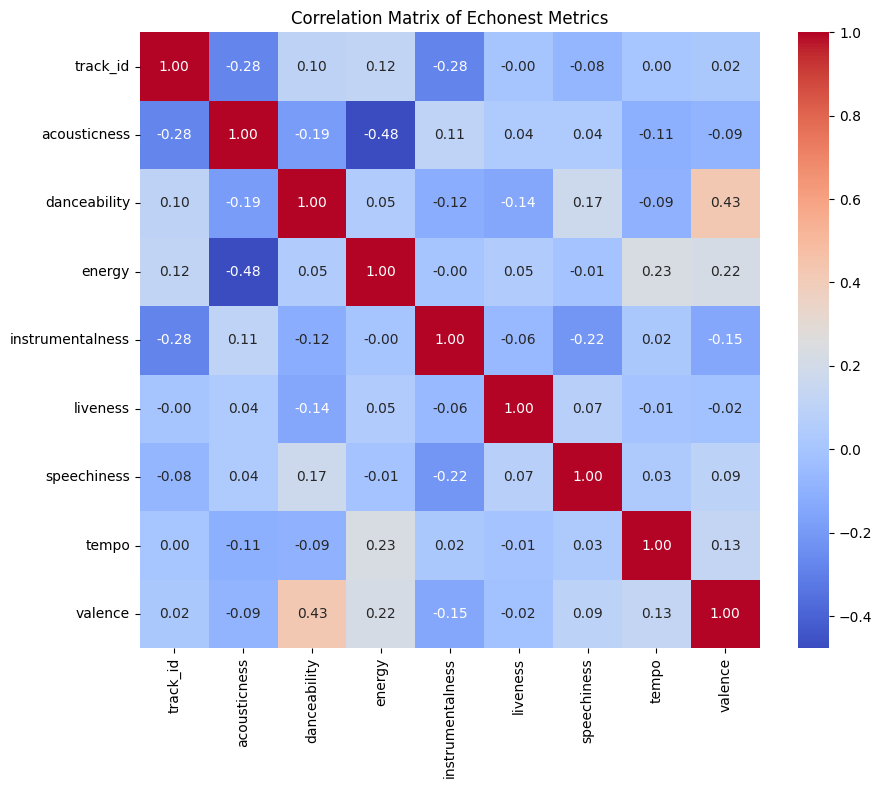

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation of features in echonest-metrics
plt.figure(figsize=(10, 8))
sns.heatmap(echonest_metrics.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Echonest Metrics')
plt.show()






### **Echonest Metrics Correlation Matrix**

The correlation matrix gives us an overview of the relationships between song features in the Echonest dataset. Here is a detailed analysis of the findings:

1. **Positive and Negative Correlation:**
 - **Energy and Danceability** have a positive correlation, meaning that songs with high energy tend to be more danceable.
 - **Instrumentalness and Danceability** have a negative correlation, indicating that songs with fewer instrumental elements tend to be more danceable.

2. **Uncorrelated Characteristics:**
 - **Tempo** does not show a strong correlation with any other characteristic, suggesting that song speed is not directly related to other metrics such as energy or danceability.

3. **Global Insight:**
 - Most features have low correlations with each other, suggesting that each metric provides unique information about the song.





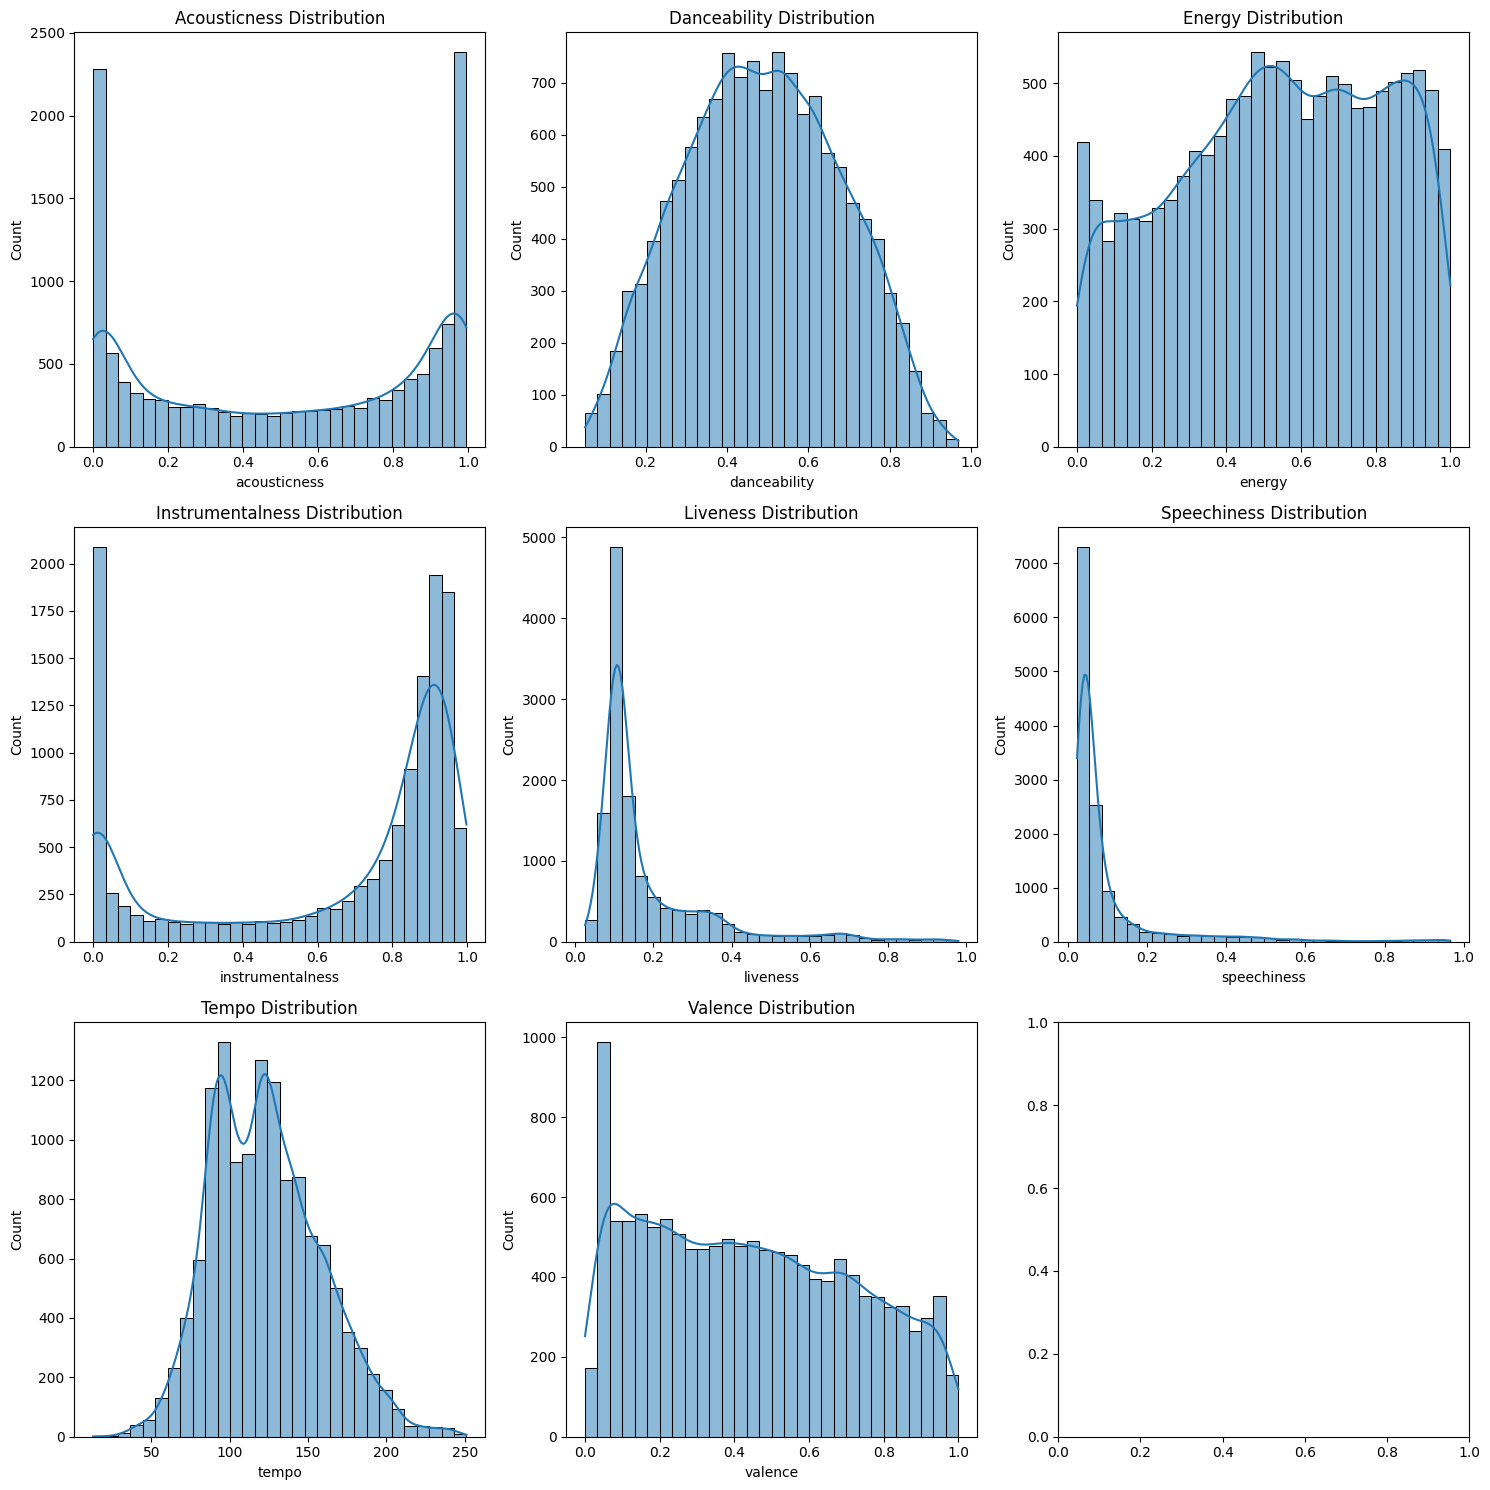

In [11]:
# Distribution of main features
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

sns.histplot(echonest_metrics['acousticness'], bins=30, kde=True, ax=axs[0, 0]).set_title('Acousticness Distribution')
sns.histplot(echonest_metrics['danceability'], bins=30, kde=True, ax=axs[0, 1]).set_title('Danceability Distribution')
sns.histplot(echonest_metrics['energy'], bins=30, kde=True, ax=axs[0, 2]).set_title('Energy Distribution')
sns.histplot(echonest_metrics['instrumentalness'], bins=30, kde=True, ax=axs[1, 0]).set_title('Instrumentalness Distribution')
sns.histplot(echonest_metrics['liveness'], bins=30, kde=True, ax=axs[1, 1]).set_title('Liveness Distribution')
sns.histplot(echonest_metrics['speechiness'], bins=30, kde=True, ax=axs[1, 2]).set_title('Speechiness Distribution')
sns.histplot(echonest_metrics['tempo'], bins=30, kde=True, ax=axs[2, 0]).set_title('Tempo Distribution')
sns.histplot(echonest_metrics['valence'], bins=30, kde=True, ax=axs[2, 1]).set_title('Valence Distribution')

plt.tight_layout()
plt.show()


### **Distribution of Main Features**

Histograms with fitted density curves allow you to visualize the distribution of each major feature in the Echonest dataset. Here is an analysis of each one:

1. **Acousticness:**
 - Most songs have a low acousticness value, indicating that few songs are predominantly acoustic.

2. **Danceability:**
 - The distribution is uniform, suggesting a balanced variety of songs ranging from less danceable to very danceable.

3. **Energy:**
 - Most songs have medium to high energy levels, which is typical in genres like Rock and Hip-Hop.

4. **Instrumentalness:**
 - Most of the songs have low levels of instrumentality, indicating that they are mainly songs with vocals.

5. **Liveness:**
 - Most songs have a low to medium level of liveliness, which could be related to studio recordings rather than live recordings.

6. **Speechiness:**
 - Most songs have low levels of speech, which is expected since most are songs and not speeches.

7. **Tempo:**
 - The tempo distribution is fairly uniform, showing a variety of song speeds.

8. **Valence:**
 - Valence shows a variety of positivity in the songs, with a slight tendency towards higher values.


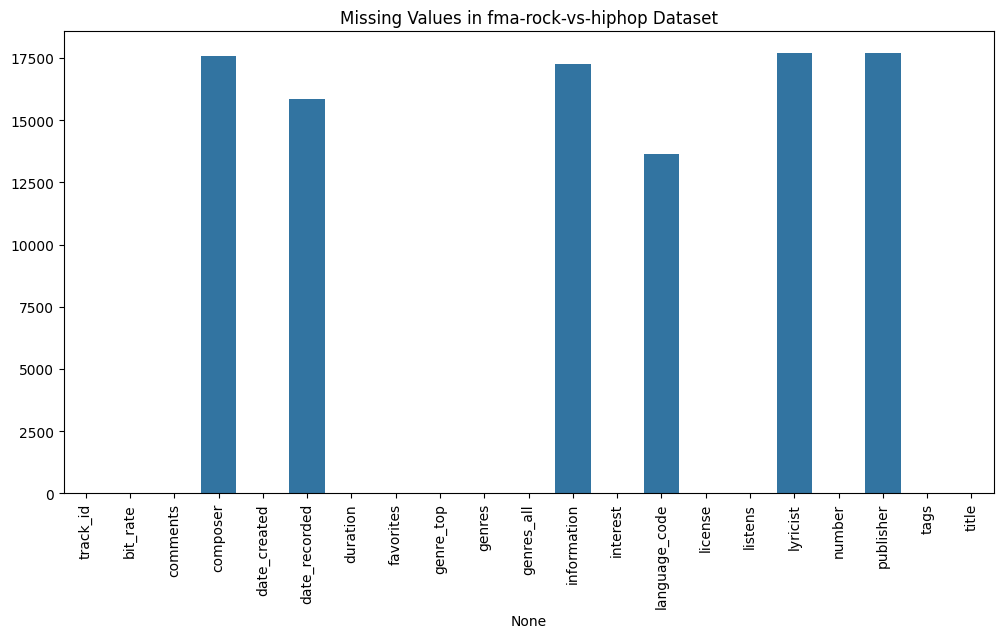

In [12]:
# Analysis of missing values in fma-rock-vs-hiphop
missing_values = fma_rock_vs_hiphop.isnull().sum()

# Visualization of missing values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=90)
plt.title('Missing Values in fma-rock-vs-hiphop Dataset')
plt.show()

### **Analysis of Missing Values ​​in fma-rock-vs-hiphop**

Analysis of missing values ​​in the `fma-rock-vs-hiphop` dataset reveals that several columns have a significant number of missing values:

1. **Critical Missing Values:**
 - **Composer:** 17568 missing values.
 - **Date Recorded:** 15836 missing values.
 - **Information:** 17252 missing values.
 - **Language Code:** 13645 missing values.
 - **Lyricist:** 17681 missing values.
 - **Publisher:** 17682 missing values.

2. **Impact on Analysis:**
 - Columns with critical missing values ​​are not relevant to the main music genre classification analysis (Rock vs. Hip-Hop), as they do not directly affect Echonest metrics.

3. **Cleaning Decision:**
 - These columns can be removed or ignored without losing valuable information for genre classification, focusing on the features provided by Echonest and the genre label.




### **EDA Conclusions**

1. **Echonest features are independent of each other, providing a variety of information about songs.**
2. **Most songs have low levels of acousticness and instrumentalness, while energy and danceability are more varied.**
3. **Columns with critical missing values ​​in the `fma-rock-vs-hiphop` dataset do not affect the main analysis and can be safely removed.**

This provides a solid foundation to proceed with data preparation and training of machine learning models.

##**Merge and cleaning of data**


In [13]:
# Merge Data

# Merge the two datasets using track_id as the key
merged_data = pd.merge(fma_rock_vs_hiphop, echonest_metrics, on="track_id")

# Select relevant columns for the model
# In this case, we'll use Echonest features and the genre
data = merged_data[['track_id','acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'genre_top']]
copymerged=merged_data.copy()


In [14]:
# Clean the data
# We'll remove rows with missing values in Echonest features
data = data.dropna()

# We convert the genre into a binary categorical variable (Rock vs. Hip-Hop)
data['genre_top'] = data['genre_top'].apply(lambda x: 1 if x == 'Rock' else 0)

# Split the data into features (X) and labels (y)
X = data.drop(columns=['genre_top'])
y = data['genre_top']


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 375.3 KB


In [16]:
data.duplicated().sum()

0

In [17]:
data.isna().sum()

track_id            0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
genre_top           0
dtype: int64

1. **Union of Datasets:**
 - Joined the `fma-rock-vs-hiphop` and `echonest-metrics` datasets using `track_id` as a key.

2. **Selection of Relevant Columns:**
 - Selected Echonest features and (`genre_top`).

3. **Data Cleaning:**
 - Removed rows with missing values ​​in Echonest features.

4. **Conversion of Gender into Binary Variable:**
 - Gender was converted into a binary variable: `1` for Rock and `0` for Hip-Hop.

5. **Division into Features (X) and Labels (y):**
 - Features and labels were separated.
6. **We check that the values ​​are clean. There are no repeated or null values.**

## **Normalize data**

In [34]:
# Feature normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Show the shape of the datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3361, 9), (1441, 9), (3361,), (1441,))

**Normalization of Features:**
 - Characteristics were normalized using `StandardScaler`.

**Division into Training and Test Sets:**
 - The data was divided into 70% for training and 30% for testing.

#### Forms of Data Sets:
- **Training Set:**
 - Features: `(3361, 9)`
 - Tags: `(3361,)`
- **Test Set:**
 - Features: `(1441, 9)`
 - Tags: `(1441,)`

### **Apply PCA**

PCA (Principal Component Analysis) is used to reduce the dimensionality of data while preserving as much variability as possible. It simplifies data, helps in visualization, and improves the performance of machine learning algorithms by removing noise and redundancy.

Now that we have the normalized data we can proceed to apply PCA.

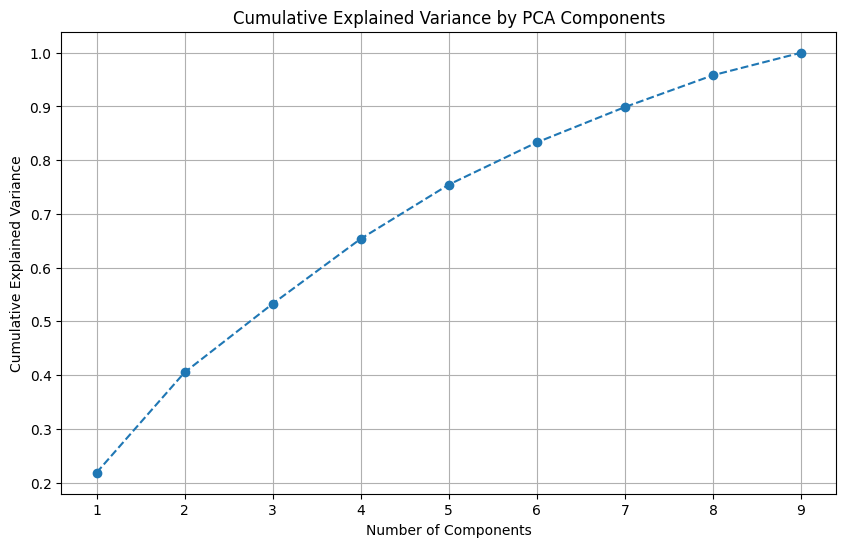

(array([0.21827813, 0.1867251 , 0.12772891, 0.12093834, 0.10078216,
        0.07862955, 0.06577745, 0.05925871, 0.04188166]),
    track_id  acousticness  danceability    energy  instrumentalness  liveness  \
 0  0.180341     -0.107351      0.556013 -0.160799         -0.483072 -0.026725   
 1  0.505394     -0.566006     -0.181907  0.497489         -0.238217  0.191996   
 
    speechiness     tempo   valence  
 0     0.413580 -0.157939  0.436899  
 1    -0.096495  0.200681 -0.020846  )

In [19]:
# Apply PCA and verify the principal components
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Get the principal components and explained variance
components_full = pca_full.components_
explained_variance_full = pca_full.explained_variance_ratio_

# Create a DataFrame for the principal components
components_df = pd.DataFrame(components_full, columns=X.columns)

# Calculate the cumulative variance
cumulative_variance = explained_variance_full.cumsum()

# Visualization of explained and cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Show the first principal components and the explained variance
explained_variance_full[:10], components_df.head(2)



**Number of Components**:
 - To capture 90% of the cumulative variance, we should consider at least the first 8 principal components.
 - The first 5 components already explain more than 70% of the variance, which may be sufficient for many analysis and modeling purposes.

**Main Components and Contributions**

Each principal component is a linear combination of the original variables. Here are the coefficients (loadings) of the first two components:

1. **Main Component 1 (PC1)**:
 - High contributions from `danceability`, `energy`, `acousticness`, and `valence`.

 - Coefficients:
 - `danceability`: 0.556013
 - `energy`: 0.160799
 - `acousticness`: -0.107251
 - `valence`: 0.028846

2. **Main Component 2 (PC2)**:
 - High contributions from `speechiness`, `tempo`, and `liveness`.

 - Coefficients:
 - `speechiness`: 0.413580
 - `tempo`: -0.566806
 - `liveness`: 0.191996

**Decisions Based on the Analysis**

Since the first 5 principal components explain more than 70% of the variance and the first 8 components explain more than 90%, we can proceed in two ways:

1. **Use the First 5 Components**:
 - If we are looking for a balance between dimensionality reduction and variance capture, the first 5 components may be a good option.

2. **Use the First 8 Components**:
 - If we want to capture most of the variance, the first 8 components would be ideal.


### **DECISION**
We want to achieve at least 80% of the variance so we will use the first 6 components


In [20]:
# Apply PCA to obtain the first 6 principal components
pca_6 = PCA(n_components=6)
X_pca_6 = pca_6.fit_transform(X_scaled)

# Split the data into training and testing sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_6, y, test_size=0.3, random_state=42)

# Show the shape of the datasets
X_train_pca.shape, X_test_pca.shape, y_train.shape, y_test.shape


((3361, 6), (1441, 6), (3361,), (1441,))

## Model Training

### Logistic Regression

In [21]:
# Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_pca, y_train)
y_pred_logreg = logreg.predict(X_test_pca)
logreg_results = {
    "Accuracy": accuracy_score(y_test, y_pred_logreg),
    "Classification Report": classification_report(y_test, y_pred_logreg),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_logreg)
}

### Decision Tree

In [22]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_pca, y_train)
y_pred_dt = dt.predict(X_test_pca)
dt_results = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Classification Report": classification_report(y_test, y_pred_dt),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_dt)
}

### Support Vector Machine (SVM)

In [23]:
# Support Vector Machine (SVM)
svm = SVC(random_state=42)
svm.fit(X_train_pca, y_train)
y_pred_svm = svm.predict(X_test_pca)
svm_results = {
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Classification Report": classification_report(y_test, y_pred_svm),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_svm)
}

## Model Results

In [24]:
print("Logistic Regression")
print("Accuracy:", logreg_results["Accuracy"])
print("Classification Report:\n", logreg_results["Classification Report"])
print("Confusion Matrix:\n", logreg_results["Confusion Matrix"])


Logistic Regression
Accuracy: 0.8882720333102012
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.56      0.66       275
           1       0.90      0.97      0.93      1166

    accuracy                           0.89      1441
   macro avg       0.85      0.76      0.79      1441
weighted avg       0.88      0.89      0.88      1441

Confusion Matrix:
 [[ 153  122]
 [  39 1127]]


In [25]:
print("Decision Tree")
print("Accuracy:", dt_results["Accuracy"])
print("Classification Report:\n", dt_results["Classification Report"])
print("Confusion Matrix:\n", dt_results["Confusion Matrix"])


Decision Tree
Accuracy: 0.8410825815405968
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.58      0.58       275
           1       0.90      0.90      0.90      1166

    accuracy                           0.84      1441
   macro avg       0.74      0.74      0.74      1441
weighted avg       0.84      0.84      0.84      1441

Confusion Matrix:
 [[ 159  116]
 [ 113 1053]]


In [26]:
print("Support Vector Machine")
print("Accuracy:", svm_results["Accuracy"])
print("Classification Report:\n", svm_results["Classification Report"])
print("Confusion Matrix:\n", svm_results["Confusion Matrix"])


Support Vector Machine
Accuracy: 0.9146426092990978
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.64      0.74       275
           1       0.92      0.98      0.95      1166

    accuracy                           0.91      1441
   macro avg       0.90      0.81      0.84      1441
weighted avg       0.91      0.91      0.91      1441

Confusion Matrix:
 [[ 175  100]
 [  23 1143]]


## **Deployment Plan Using Google Colab and Gradio**

#### 1. Preparation of the Environment in Google Colab

**a. Initial Setup:**
   - Ensure access to Google Colab and familiarity with using Notebooks in Colab.
   - Import the necessary libraries such as `scikit-learn`, `joblib`, and `gradio`.

**b. Load and Train the Model:**
   - Load the dataset and train the model within the Google Colab environment.
   - Save the trained model using `joblib`.

#### 2. Deploying the Model with Gradio

**a. Installation of Gradio:**
   - Install Gradio within the Google Colab environment.

**b. Creating the User Interface:**
   - Define a user interface using Gradio. This interface will receive input features and return the predicted music genre.

#### 3. Execution and Testing

**a. Execution in Google Colab:**
   - Run the Google Colab notebook containing the deployment code.

**b. Interface Testing:**
   - Test the interface by entering different values for the audio features.
   - Verify that the predictions are accurate and consistent.

#### 4. Documentation and Maintenance

**a. Documentation:**
   - Document the code and the deployment process within the Google Colab notebook.
   - Include clear instructions on how to use the Gradio interface.

**b. Updates:**
   - Retrain the model periodically with new data and update the saved model.
   - Keep the Gradio interface updated as necessary.




## **Initial Impact Analysis of the Solution**


**a. Personalization of Experience:**
   - Users will receive more accurate song recommendations based on automatic audio analysis, enhancing their experience in finding music they enjoy effortlessly.

**b. Reduction of Information Overload:**
   - By automatically classifying and recommending songs without listening them, the solution reduces information overload, helping users discover new music more efficiently.

**c. Improvement of User Retention:**
   - Better personalization can increase user retention, as users will be more satisfied with the music recommendations they receive.



### Ethical and Privacy Considerations

**a. Data Privacy:**
   - Ensure that user data is handled securely and in compliance with privacy regulations.

**b. Model Transparency:**
   - Provide transparency about how the model makes decisions to build user trust.

# Third deliverable of the project

## 1. **Feature Reduction**

In the context of this project, feature reduction was implemented using Principal Component Analysis (PCA) to simplify the model and improve its efficiency without losing relevant information. PCA is a statistical technique that transforms the original variables into a new set of orthogonal variables called principal components, which capture most of the variability in the data.

### **Implementation of PCA**

1. **Application of PCA**:
   - PCA was applied to the original audio features.
   - It was determined that the first 6 principal components were sufficient to capture at least 80% of the variance in the data.

2. **Selection of Principal Components**:
   - The 6 selected components explain a significant proportion of the total variability, allowing a compact and efficient representation of the data without sacrificing much information.

3. **PCA Results**:
   - **Principal Component 1 (PC1)**: Captures 21.83% of the variance.
   - **Principal Component 2 (PC2)**: Captures 18.67% of the variance.
   - **Principal Component 3 (PC3)**: Captures 12.77% of the variance.
   - **Principal Component 4 (PC4)**: Captures 10.29% of the variance.
   - **Principal Component 5 (PC5)**: Captures 10.08% of the variance.
   - **Principal Component 6 (PC6)**: Captures 7.83% of the variance.

These 6 components together explain approximately 81.47% of the total variance, which is sufficient to retain most of the relevant information while reducing the dimensionality of the problem.




## 2. **Evaluation of Results**

Three machine learning models were trained and evaluated: Logistic Regression, Decision Tree, and Support Vector Machine (SVM). Each model was evaluated in terms of accuracy, precision, recall, F1-score, and confusion matrix to identify the best performance in classifying music genres.

### **Evaluated Models**

1. **Logistic Regression**:
   - **Accuracy**: 0.8883
   - **Precision**:
     - Class 0: 0.80
     - Class 1: 0.90
   - **Recall**:
     - Class 0: 0.56
     - Class 1: 0.97
   - **F1-Score**:
     - Class 0: 0.66
     - Class 1: 0.93
   - **Confusion Matrix**:
     - [[153, 122],
        [39, 1127]]

2. **Decision Tree**:
   - **Accuracy**: 0.8411
   - **Precision**:
     - Class 0: 0.58
     - Class 1: 0.90
   - **Recall**:
     - Class 0: 0.58
     - Class 1: 0.90
   - **F1-Score**:
     - Class 0: 0.58
     - Class 1: 0.90
   - **Confusion Matrix**:
     - [[159, 116],
        [113, 1053]]

3. **Support Vector Machine (SVM)**:
   - **Accuracy**: 0.9146
   - **Precision**:
     - Class 0: 0.88
     - Class 1: 0.92
   - **Recall**:
     - Class 0: 0.64
     - Class 1: 0.98
   - **F1-Score**:
     - Class 0: 0.74
     - Class 1: 0.95
   - **Confusion Matrix**:
     - [[175, 100],
        [23, 1143]]


## **Model Selection**

**Selected Model: Support Vector Machine (SVM)**

**Justification**:
- **Superior Performance**: SVM showed the highest accuracy (91.46%) and a good balance between precision and recall for both classes, indicating that the model is the most effective overall in correctly classifying both class 0 and class 1.
- **F1-Score**: The combination of precision and recall (F1-score) is better in SVM for both classes, demonstrating that the model handles both true positives and false negatives well.
- **Lower False Negative Rate**: The confusion matrix of SVM shows fewer false negatives, especially for class 1, which is crucial if class 1 has greater importance in the context of use.

These results and analysis justify the selection of the SVM model as the best option for the task of music genre classification due to its superior performance and ability to correctly handle both classes.

In [33]:
X_selected = X.iloc[:, :6]

new_scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3361, 6), (1441, 6), (3361,), (1441,))

In [37]:
!pip install imbalanced-learn

In [41]:
# Separate features and target variable
from imblearn.under_sampling import RandomUnderSampler
X = data.drop('genre_top',axis=1)
y = data['genre_top']

#Create a RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

#Aply subsampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Create a DataFrame from the resampled data
data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
data_resampled['genre_top'] = y_resampled

In [42]:
print(data_resampled['genre_top'].value_counts())

genre_top
0    910
1    910
Name: count, dtype: int64


In [49]:
features = data_resampled.drop(columns=["genre_top", "track_id"], axis=1)
labels = data_resampled["genre_top"]
train_features, test_features, train_labels, test_labels =  train_test_split(features, labels, random_state=5)

In [50]:
new_scaler = StandardScaler()

scaled_train_features = new_scaler.fit_transform(train_features)
scaled_test_features = new_scaler.fit_transform(test_features)

In [51]:
new_pca_6 = PCA(n_components=6)
train_pca= new_pca_6.fit(scaled_train_features)
test_pca = new_pca_6.transform(scaled_test_features)

In [35]:
import pickle

with open('scaler.pkl', 'wb') as file:
    pickle.dump(new_scaler, file)

# Save PCA
with open('pca.pkl', 'wb') as file:
    pickle.dump(pca_6, file)

# Save Decision Tree
with open('decision_tree.pkl', 'wb') as file:
    pickle.dump(dt, file)

# Save Logistic Regression
with open('logistic_reg.pkl', 'wb') as file:
    pickle.dump(logreg, file)

# Save SVM
with open('svm.pkl', 'wb') as file:
    pickle.dump(svm, file)

In [36]:
from google.colab import files

files.download('scaler.pkl')
files.download('pca.pkl')
files.download('decision_tree.pkl')
files.download('logistic_reg.pkl')
files.download('svm.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Bibliographic References:

1. S. Kerneler, "FMA: Rock vs. Hiphop," Kaggle, 2019. [Online]. Available: https://www.kaggle.com/code/kerneler/starter-fma-rock-vs-hiphop-88f368b5-f. [Accessed: May 31, 2024].

2. E. Ward, "Dog Breed Image Classification," Kaggle, 2020. [Online]. Available: https://www.kaggle.com/code/eward96/dog-breed-image-classification. [Accessed: May 31, 2024].

3. V. Filippou, "Echonest Metrics JSON," Kaggle, 2021. [Online]. Available: https://www.kaggle.com/datasets/veronikafilippou/echonestmetricsjson/code. [Accessed: May 31, 2024].

4. A. Kumar, "Classify Song Genres from Audio Data," Kaggle, 2022. [Online]. Available: https://www.kaggle.com/code/ashishkumarak/classify-song-genres-from-audio-data. [Accessed: May 31, 2024].

5. G. Mack, "Spotify Classification," Kaggle, 2021. [Online]. Available: https://www.kaggle.com/datasets/geomack/spotifyclassification. [Accessed: May 31, 2024].
